In [455]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition


In [456]:
'''
Читаем данные из файла, и сразу смотрим заголовки столбцов (название фич) и первые 5 строк.

'''
df = pd.read_csv('D:/Git/ml_data.mining/data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


Размер датасета: 10002 записи, и 14 колонок

In [457]:
# ТОDO: определите общее количество записей набора данных
df.shape 

(10002, 14)

In [458]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [459]:
# ТОDO: определите, имеются ли пропущенные значения
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

Удаление строк с пропущенными значениями

In [460]:
df = df.dropna()

Удаление неужных столбцов

In [461]:
df = df.drop(['RowNumber','CustomerId', 'Surname', 'Gender', 'EstimatedSalary'], axis=1)

In [462]:
'''
Определяет, является ли столбец числовым или категориальным.
:параметр
     :param dtf: dataframe - входные данные
     :param col:str - имя столбца для анализа
     :param max_cat: num — максимальное количество уникальных значений для распознавания столбца как категориального
:возвращает
     "cat", если столбец является категориальным или "num" в противном случае


Recognize whether a column is numerical or categorical.
:parameter
    :param df: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(df, col, max_cat=100):
    if (df[col].dtype == "O") | (df[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

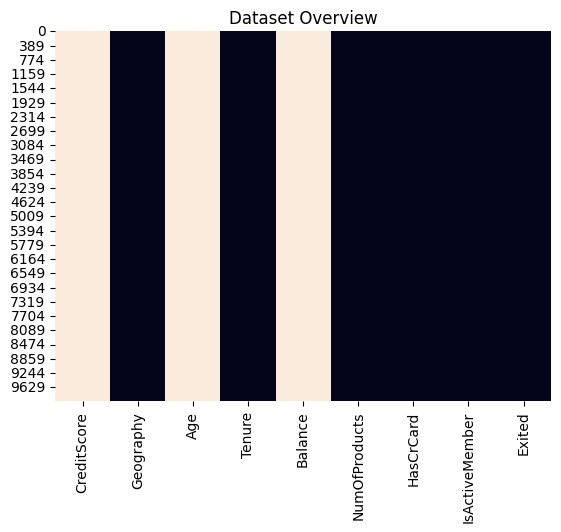

 Categerocial   Numeric   NaN 


In [463]:
'''
формируем словарь dic_cols.
Ключи - название фич
Значение - категориальный (cat) или числовой (num)
'''
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

'''
df.isnull() - возвращает датасет, который похож на изначальный датасет df, но в каждой ячейке вместо значений написано:
 False (если значение есть)
 True  (если в ячейке отсутствует значение)
'''
heatmap = df.isnull()

'''
А дальше проходим по столбцам, и меняем значения:
 если столбец числовой:
    пишем 0.5, если значение False (то есть оно не нулевое)
    пишем 1,   если значение True

 если столбец категориальный
    пишем 0, если значение False   (то есть оно не нулевое)
    пишем 1,   если значение True

После этого у нас окажется, что значения могут принимать всего три различных значения.
'''
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

'''
Строим heatmap (тепловую карту)
0.5 - если значение есть и оно числовое
0   - если значение есть и оно категориальное
1   - если значения в ячейке нет
'''
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')

plt.show()

'''
Печатаем внизу подобие легенды, раскрашивая так, как нужно.
'''
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

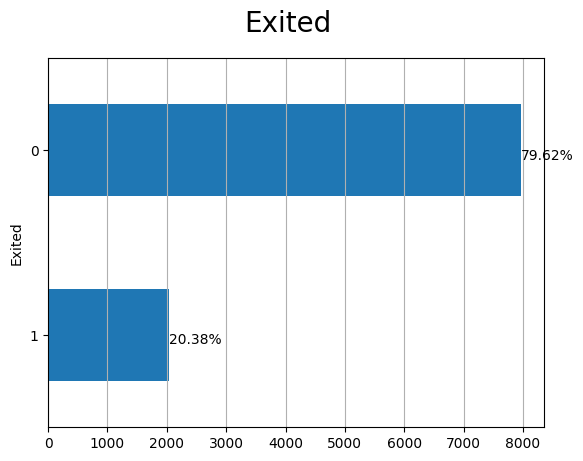

In [464]:
'''
Анализируем, какое количество пингвинов в различных видах (species)
другими словами, мы группируем все объекты по их целевой переменной (species) и просто считаем, сколько объектов попало в каждую группу
'''

#y = "species"  # вот тут задаем название столбца, по значению в котором и будем группировать
y ="Exited"
'''
далее считаем количество объектов с одинаковыми значениями в столбце y: dtf[y].value_counts()
потом сортируем полученное sort_values()
и задаем plot
'''
ax = df[y].value_counts().sort_values().plot(kind="barh")

'''
Затем занимаемся тем, что формируем надписи для графика
'''
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)

'''
И наконец-то отрисовываем
'''
plt.show()

C:\Users\kanze\AppData\Local\Temp\ipykernel_8136\4069024775.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])#зададим данные для графика
c:\Users\kanze\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


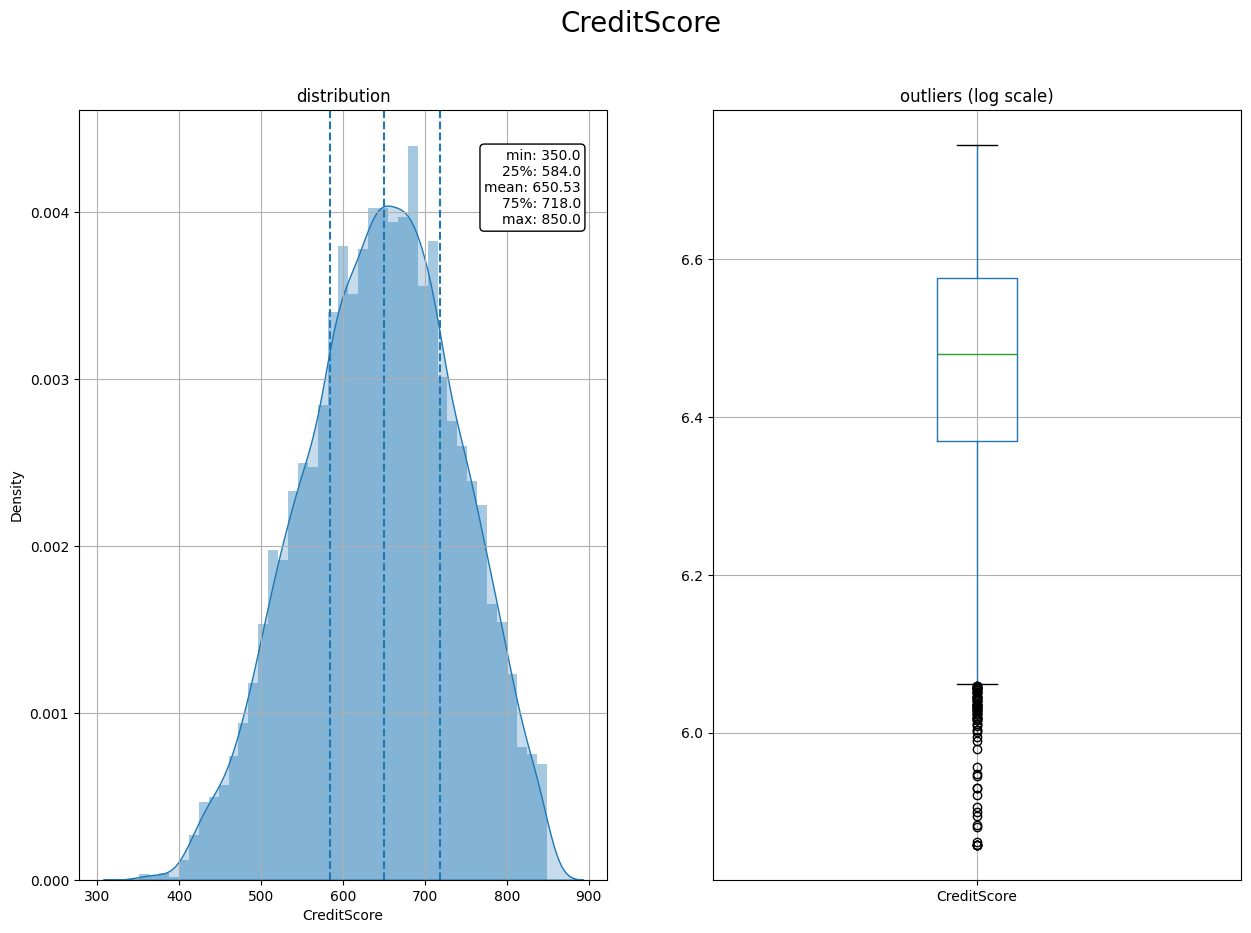

In [465]:
'''
Используем блочную диаграмму для графического отображения групп данных через их квартили.
Построим целевую пременную "body_mass_g"
'''

x = "CreditScore"
#x = "culmen_depth_mm"
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).


'''

fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(15, 10))
fig.suptitle(x, fontsize=20)#задаем заголовок основного рисунка
'''
Пропишем распределение:
'''
### distribution
ax[0].title.set_text('distribution')#задаем название
variable = df[x].fillna(df[x].mean())#замена отсутствующих значений в датафрейме на средние
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))#вычисляем q-й квантиль заданных данных вдоль указанной оси.
variable = variable[ (variable > breaks[0]) & (variable <
                                               breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])#зададим данные для графика
des = df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
'''
 Формируем надписи для графика
'''
### boxplot

ax[1].title.set_text('outliers (log scale)')#устанавливаем заголовок
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
'''
Отрисовываем
'''

plt.show()

In [466]:
'''
А теперь обернем все, что было в предыдущей ячейке - в функцию для удобства повторного использования.
show_dist
'''

def show_dist(x, df):
    '''
    :param x: название столбца
    :param dtf: датасет
    :return: ничего не возвращает
    '''
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = df[x].fillna(df[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
                 ax=ax[0])  #Запишем чтобы создать горизонтальную гистограмму
    des = df[x].describe()


    '''
    Добавим квантильные и средние линии
     '''
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))
    '''
     Формируем надписи для графика
    '''
    ### boxplot
    ax[1].title.set_text('outliers (log scale)')  #устанавливаем заголовок
    tmp_df = pd.DataFrame(df[x])
    tmp_df[x] = np.log(tmp_df[x])
    tmp_df.boxplot(column=x, ax=ax[1])
    '''
    Отрисовываем
    '''
    plt.show()


C:\Users\kanze\AppData\Local\Temp\ipykernel_8136\242346285.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
c:\Users\kanze\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


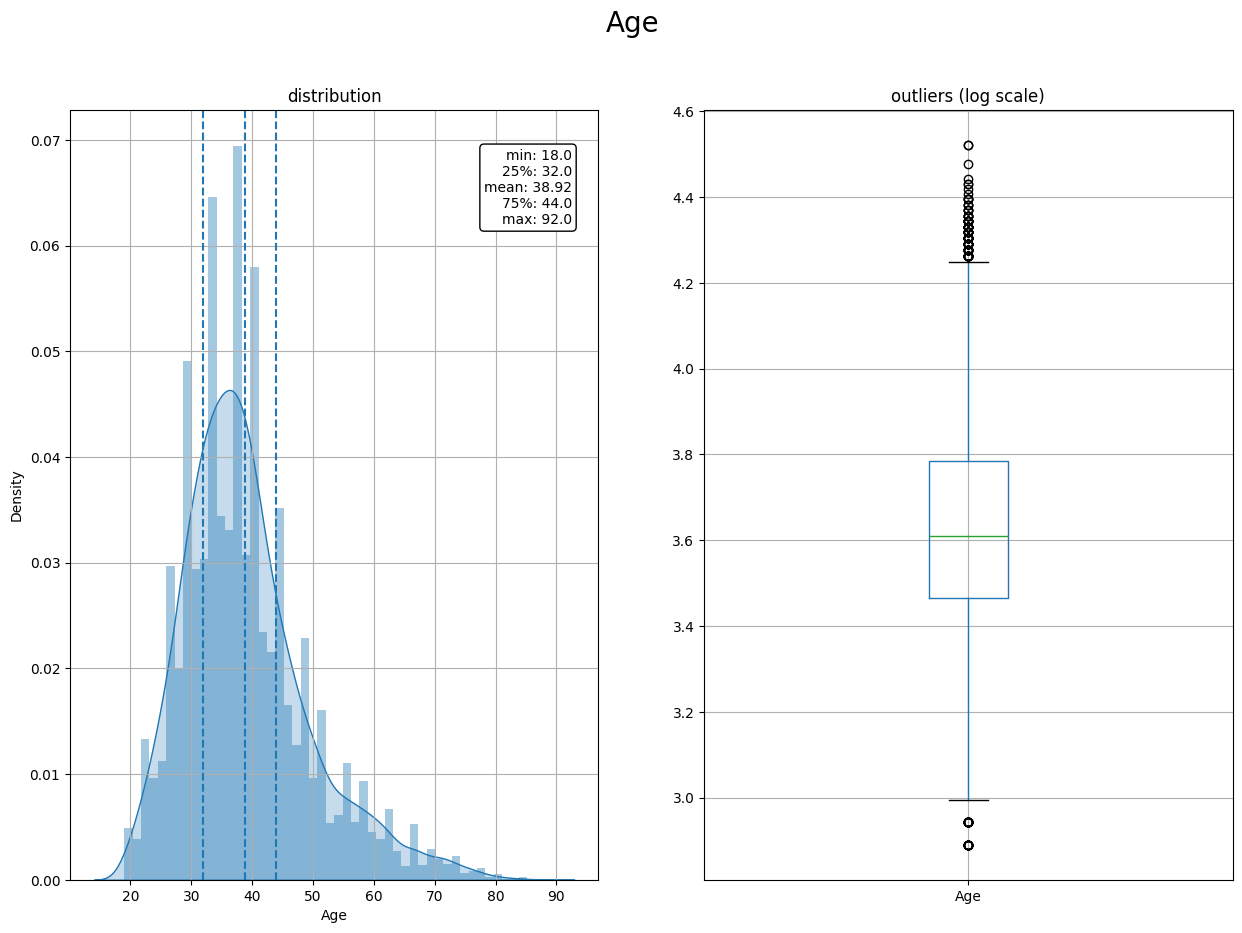

In [467]:
'''
Проверяем, как работает
'''
show_dist('Age', df)

In [468]:
'''
Подготовим структуру словаря из фрейма данных со столбцами
'''
def prep(df):
    df.loc[df.Geography == 'France', 'Geography_ind'] = 0
    df.loc[df.Geography == 'Spain', 'Geography_ind'] = 1
    df.loc[df.Geography == 'Germany', 'Geography_ind'] = 2

    '''
    axis -будут ли удалены строки или столбцы, содержащие пропущенные значения.
    how- удаляется ли строка или столбец из DataFrame, когда у нас есть хотя бы один NA или все NA.
    thresh- количество значений, не относящихся к NA
    subse-Метки вдоль другой оси, которые следует учитывать,
    например, если вы отбрасываете строки, это будет список столбцов для включения.
    inplace-Нужно ли изменять DataFrame,  не создавая новый.
    '''
    # df.drop('Unnamed: 0', axis=1, inplace=True)#Удаление указанных меток из строк / столбцов
    emdf = df.dropna(axis=0, how='any', inplace=False)#Удалм пропущенные значения
    return  emdf

In [469]:
'''
    При разделении данных на обучающие и тестовые наборы вы должны следовать одному основному правилу:
        строки в обучающем наборе не должны также появляться в тестовом наборе.
        Это потому, что модель видит целевые значения во время обучения и использует их для понимания явления.
        Другими словами, модель уже знает правильный ответ для обучающих наблюдений (.
'''

## split data , 70% - тренировочная выборка, 30% тестовая выборка
df_tr, df_t = model_selection.train_test_split(df, test_size=0.3)

# подготавливаем данные в трейне и тесте одинаково
df_train = prep(df_tr)
df_test = prep(df_t)

## print info
# print("X_train shape:", df_train.drop("species",axis=1).shape, "| X_test shape:", df_test.drop("species",axis=1).shape)
# print("y_train mean:", round(np.mean(df_train["species_ind"]),2), "| y_test mean:", round(np.mean(df_test["species_ind"]),2))
# print(df_train.drop("species",axis=1).shape[1], "features:", df_train.drop("species_ind",axis=1).columns.to_list())

print("X_train shape:", df_train.shape, "| X_test shape:", df_test.shape)
print("y_train mean:", round(np.mean(df_train["Exited"]),2), "| y_test mean:", round(np.mean(df_test["Exited"]),2))
print(df_train.shape[1], "features:", df_train.columns.to_list())

X_train shape: (6998, 10) | X_test shape: (3000, 10)
y_train mean: 0.2 | y_test mean: 0.21
10 features: ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Geography_ind']


In [470]:
# смотрим размер полученной выборки трейне.. 233 столбцов, 10 строк
df_train.shape

(6998, 10)

In [471]:
df.head(5)

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,619,France,42.0,2,0.00,1,1.0,1.0,1
1,608,Spain,41.0,1,83807.86,1,0.0,1.0,0
2,502,France,42.0,8,159660.80,3,1.0,0.0,1
3,699,France,39.0,1,0.00,2,0.0,0.0,0
5,645,Spain,44.0,8,113755.78,2,1.0,0.0,1


In [472]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
train_x = df_train[['CreditScore', 'Geography_ind', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance', 'Tenure' ]]
train_y = df_train['Exited']

In [473]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
test_x = df_test[['CreditScore', 'Geography_ind', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance', 'Tenure' ]]
test_y = df_test['Exited']

In [474]:
# нормируем значения
Y = 'species_ind'

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
X = scaler.fit_transform(train_x)#преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.
'''
 X_train - это весь экземпляр с атрибутами,
 y_train - это метка каждого экземпляра.
'''
train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head()# выводим


,CreditScore,Geography_ind,Age,NumOfProducts,HasCrCard,IsActiveMember,Balance,Tenure
3395,0.818,0.0,0.054054,0.000000,1.0,0.0,0.000000,0.5
3360,0.988,0.0,0.270270,0.000000,1.0,1.0,0.444410,0.7
5036,0.698,1.0,0.554054,0.000000,0.0,1.0,0.425749,0.3
4750,1.000,0.0,0.229730,0.000000,1.0,1.0,0.000000,0.5
4029,0.302,1.0,0.121622,0.333333,1.0,0.0,0.379962,0.4


C:\Users\kanze\AppData\Local\Temp\ipykernel_8136\242346285.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
c:\Users\kanze\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
c:\Users\kanze\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result 

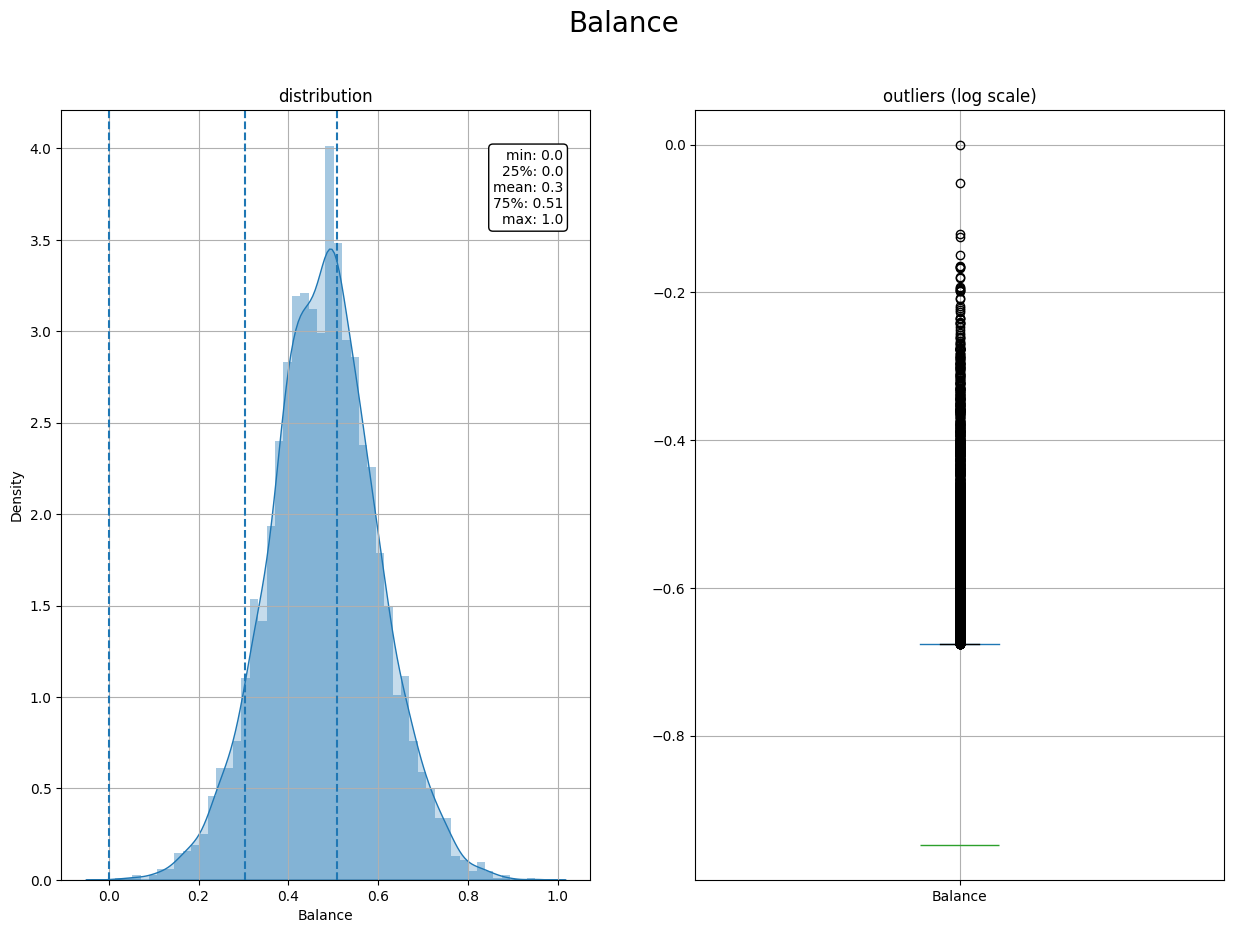

In [475]:
show_dist('Balance', train_x_scaled) #используем ранее созданную нами функцию для отрисовки графиков

C:\Users\kanze\AppData\Local\Temp\ipykernel_8136\242346285.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
c:\Users\kanze\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
c:\Users\kanze\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result 

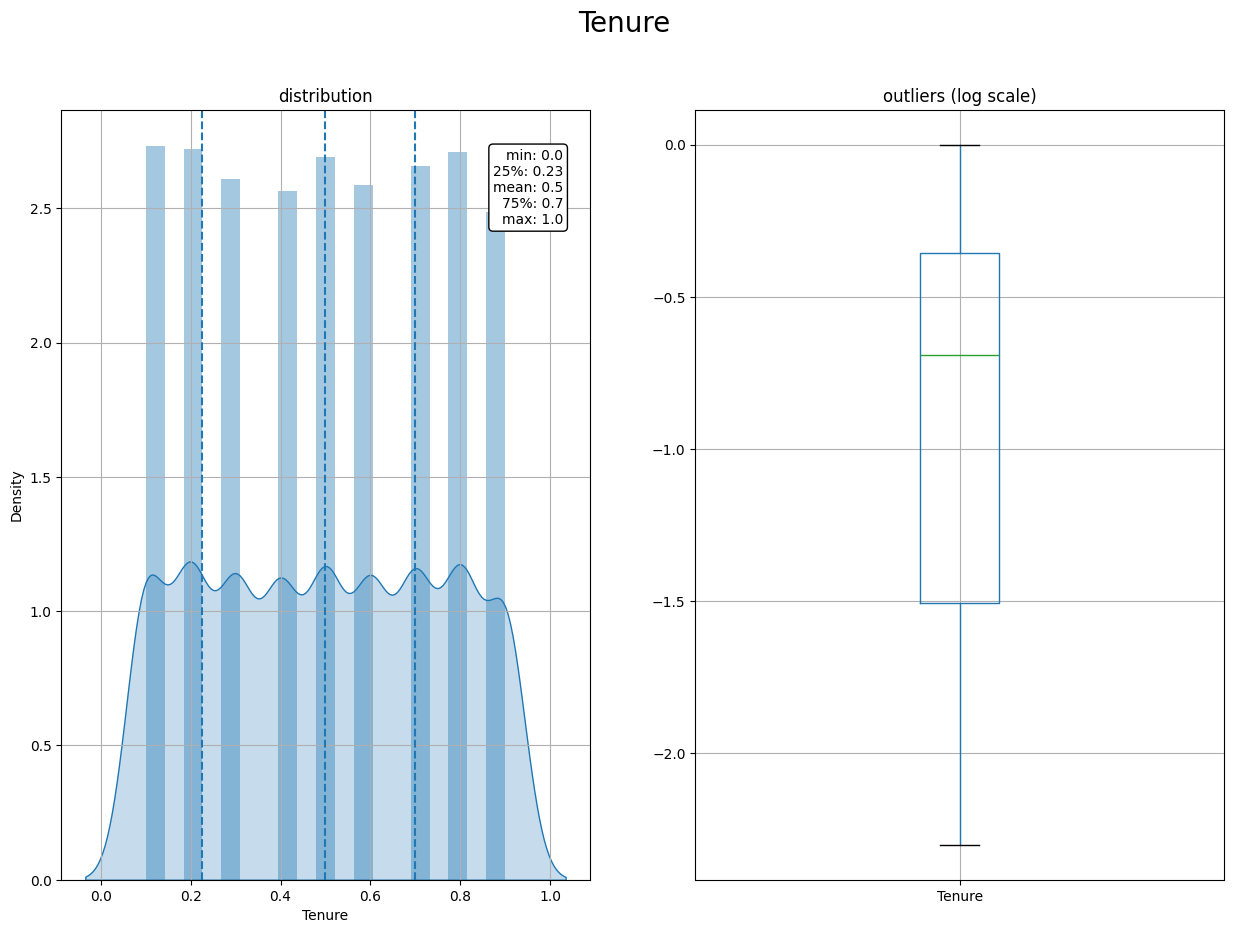

In [476]:
show_dist('Tenure', train_x_scaled) #используем ранее созданную нами функцию для отрисовки графиков

[1, 0] <class 'list'>


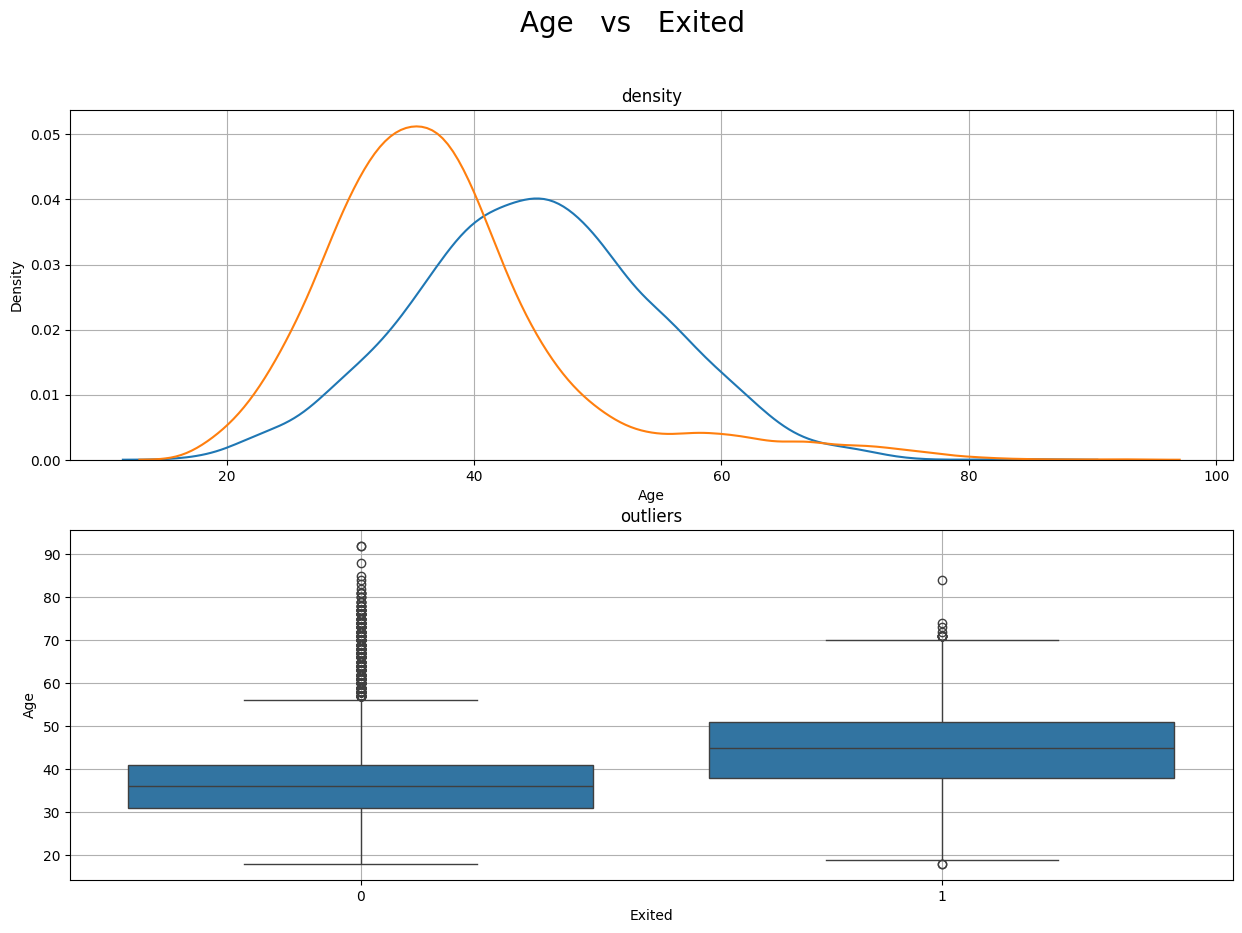

In [477]:
'''
Для того, чтобы понять, обладает ли  "body_mass_g" предсказательной силой для предсказания"species", построим график плотности распределений и усиковую диаграмму body_mass_g  для каждого уникального species.

'''

x = 'Age'

cat, num = "Exited", "Age"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))# распаковываем  кортеж в переменные figи ax.
fig.suptitle(x+"   vs   "+y, fontsize=20)# получаем объект рисунка и массив подграфиков,где первое число - количество строк,второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
'''
Пропишем распределение:
'''
tmp = df[cat].unique().tolist()
print(tmp, type(tmp))
### distribution
ax[0].title.set_text('density')
for i in df[cat].unique():  # перебираем все уникальные значения в столбце dtf[cat], cat="species"
    sns.kdeplot(df[df[cat]==i][num], hue_order=tmp,  ax=ax[0], legend=True)#Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)#Настроим линии сетки.

### boxplot
ax[1].title.set_text('outliers')#устанавливаем заголовок
sns.boxplot(x=cat, y=num, data=df, ax=ax[1])#Нарисуем блочную диаграмму, чтобы показать распределения по категориям.


ax[1].grid(True)#Настроим линии сетки.
'''
  Отрисовываем
'''

plt.show()

In [478]:
'''
Смотрим, что лежит в X, который результат нормировки train_x
'''
X

array([[0.818     , 0.        , 0.05405405, ..., 0.        , 0.        ,
        0.5       ],
       [0.988     , 0.        , 0.27027027, ..., 1.        , 0.44441016,
        0.7       ],
       [0.698     , 1.        , 0.55405405, ..., 1.        , 0.42574916,
        0.3       ],
       ...,
       [0.408     , 0.5       , 0.37837838, ..., 1.        , 0.34915909,
        0.7       ],
       [0.696     , 0.5       , 0.39189189, ..., 0.        , 0.        ,
        0.6       ],
       [0.564     , 0.        , 0.18918919, ..., 1.        , 0.44475958,
        0.6       ]])

In [479]:
'''
смотрим какие индексы (по-сути номера объектов в основном датасете) остались в трейне
'''
train_x.index


Index([3395, 3360, 5036, 4750, 4029, 4314, 1197, 7159, 6701, 6199,
       ...
       5801, 3609,  328,  926, 9593,  635, 7521, 5007, 3370, 2927],
      dtype='int64', length=6998)

In [480]:
'''
Метод fit(data) используется для вычисления среднего значения и стандартного отклонения для данной функции, которые будут использоваться в дальнейшем для масштабирования.
Метод transform(data) используется для выполнения масштабирования с использованием среднего значения и стандартного отклонения, рассчитанного с использованием метода .fit().
Метод fit_transform() выполняет как подгонку, так и преобразование.
 X_train - это весь экземпляр с атрибутами,
 y_train - это метка каждого экземпляра.
scaled_x_train - фрейм данных с именами объектов,
scaled_x_test.values - значения, без имен объектов
 '''
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index )
test_y_scaled = test_y

Text(0.5, 1.0, 'pearson correlation')

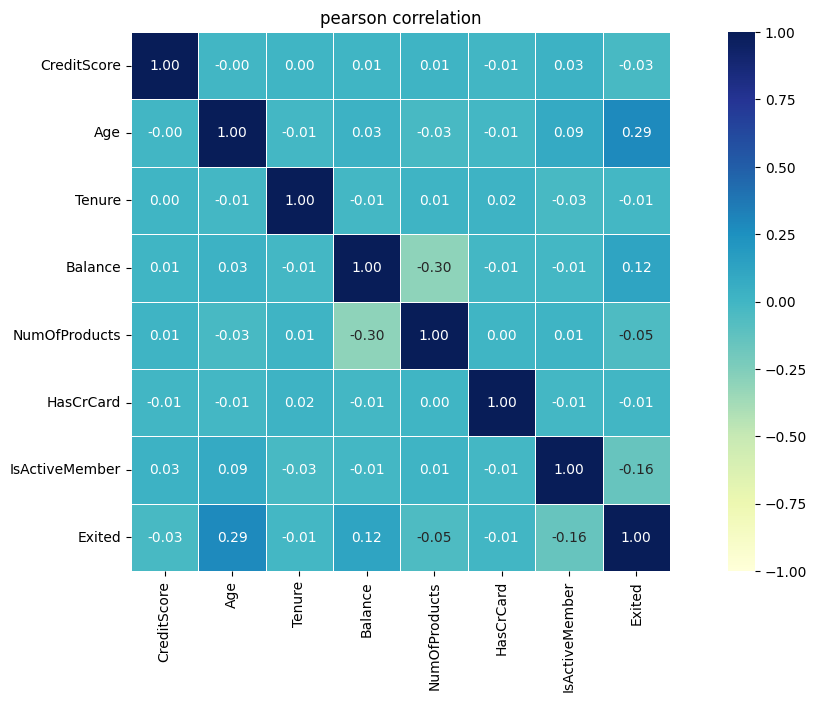

In [484]:
'''
Выбор параметров (фич, features)  — это процесс выбора для обучения модели подмножества параметров из всех параметров датасета.
Это упрощает обучение модели и уменьшает вероятность переобучения (когда модель слишком сильно адаптируется к обучающим данным и плохо работает вне набора train).

Вычислим матрицу корреляции, чтобы увидеть, какие параметры коррелируют друг с другом и целевой переменной:
 '''

corr_matrix = df.copy()
plt.figure(figsize=(15,7),dpi=100)

for col in corr_matrix.columns: #зададим условия для столбцов
 '''
 corr_matrix принимает входное отношение с числовыми столбцами и вычисляет коэффициент корреляции Пирсона между  каждой парой входных столбцов и возвращает матрицу корреляции в формате триплета.
 То есть каждая парная корреляция идентифицируется тремя возвращаемыми столбцами:
 имя первой переменной,  имя второй переменной и значение корреляции пары.
 Функция также возвращает два дополнительных столбца: number_of_ignored_input_rows и number_of_processed_input_rows.
 Значение четвертого/пятого столбца указывает количество строк из ввода, которые игнорируются/используются  для вычисления соответствующего значения корреляции.
 Любая входная пара с NULL, Inf или NaN игнорируется.

Корреляционная матрица симметрична со значением 1 на всех диагональных элементах
 '''

if corr_matrix[col].dtype == "O":
        corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)
'''
Основная цель Seaborn heatmap — визуализировать correlation matrix  для feature selection для решения задач.
Vmin и vmax устанавливают нижнюю и верхнюю границы цветовой полосы

Чтобы изменить цвет heatmap , используют параметр cmap (colormap) sns.heatmap

Каждая ячейка sns.heatmap отображается по номеру, и если нужно  показать этот номер в ячейке,
тогда используется sns.heatmap() annot (annotation) Если записать « True » в annot ,
это значение будет отображаться в каждой ячейке .

fmt позволяет добавлять строковые (текстовые) значения в ячейку.

Cbar по умолчанию имеет логическое значение True, если поменять его намFalse, то цветная полоса скрывается.
'''
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

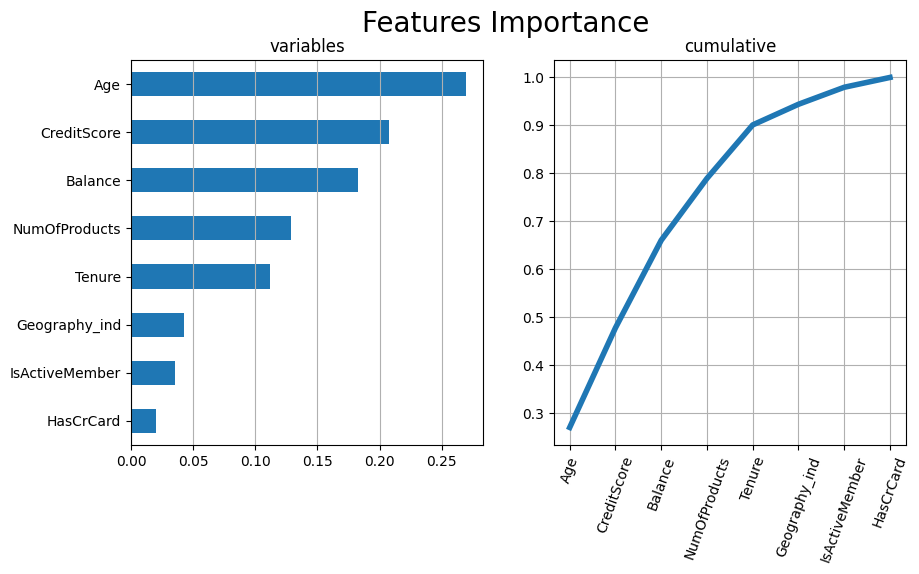

In [485]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
df_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")


## Plot
'''
 Формируем надписи для графика

 ticks : подобный массиву, содержащий список местоположений xtick. Передача пустого списка удаляет все xticks. (По желанию)
labels : подобный массиву, содержащий метки для размещения в заданных местах тиков. Этот аргумент может быть передан только в том случае, если также переданы тики. (По желанию)
kwargs : текстовые свойства, которые можно использовать для управления внешним видом меток.
Функция Matplotlib xticks() возвращает:
locs: список местоположений xtick.
labels: список текстовых объектов xlabel
plt.grid - Настройка линий сетки.
axis - Ось, к которой применяются изменения.


'''
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
df_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)),
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

In [488]:
'''
Проектирование, обучение, тестирование и оценка модели машинного обучения:
'''
X_train = train_x_scaled[['CreditScore', 'Geography_ind', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance', 'Tenure']]
y_train = train_y_scaled

X_test = test_x_scaled[['CreditScore', 'Geography_ind', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance', 'Tenure']]
y_test = test_y_scaled

In [489]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг. Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений.
 Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом,
 что каждая последующая модель сводит ошибку предыдущей к минимуму.
 Оценивать качество предсказаний будем по RandomizedSearchCV
'''

## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],    #максимальная глубина дерева
             'min_samples_split':[2,4,6],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],     #минимальное количество выборок для формирования листа
             'max_features':[2,3,4],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла
## random search(Рандомизированный поиск по гиперпараметрам.)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне

Best Model parameters: {'subsample': 0.9, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.05}
Best Model mean accuracy: 0.8679631369345451


In [490]:
'''
X_train - это тренировочный датасет
y_train - это целевая переменная для каждого объекта в X_train.
'''
## train
## заполняем модель данным из трайн датасетов
model.fit(X_train, y_train)
## test
predicted_prob = model.predict_proba(X_test) #прогнозирование
'''
Функция Predict() принимает только один аргумент , который представляет собой test датасет.
'''
predicted = model.predict(X_test).astype('int32')

In [491]:
'''
смотрим, что получили
А получили мы для каждого объекта - вектор вероятностей отнесения этого объекта к классам species
'''
predicted_prob

array([[0.95818419, 0.04181581],
       [0.84804964, 0.15195036],
       [0.94741103, 0.05258897],
       ...,
       [0.73962124, 0.26037876],
       [0.86891419, 0.13108581],
       [0.94553117, 0.05446883]])

In [492]:
# а это истинное значение, кто к какому классу относится
y_test.astype('int32') #astype -  позволяет преобразовывать тип данных существующего столбца данных в набор данны

8628    0
2229    0
6634    0
2907    0
6600    1
       ..
9636    1
9722    0
2114    0
9974    0
826     0
Name: Exited, Length: 3000, dtype: int32

In [498]:
## Accuray e AUC
'''
Теперь смотрим метрики.
НА ТЕСТОВОМ ДАТАСЕТЕ
'''
accuracy = metrics.accuracy_score(y_test, predicted)#Оценим точность классификации.

auc = metrics.roc_auc_score(np.array(y_test), np.array(predicted),average= "weighted") #возвращаем долю правильно классифицированных выборок.
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
'''
Получим результат
'''

## Precision e Recall
recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.85
Auc: 0.7
Recall (all 1s predicted right): 0.85
Precision (confidence when predicting a 1): 0.84
Detail:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2374
           1       0.72      0.45      0.55       626

    accuracy                           0.85      3000
   macro avg       0.79      0.70      0.73      3000
weighted avg       0.84      0.85      0.83      3000



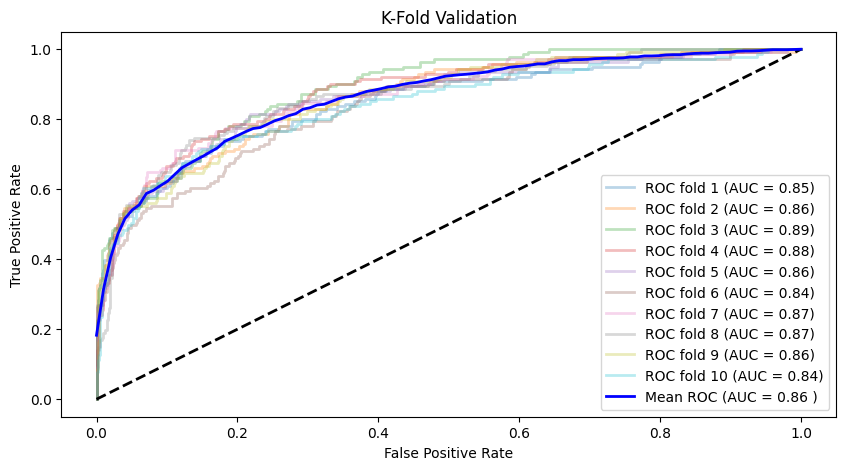

In [499]:
'''
Строим ROC кривые
'''
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    '''
iloc - позволяет получить определенное значение, принадлежащее к строке и столбцу,
используя указанные значения индекса
X_train - это весь экземпляр с атрибутами,
y_train - это метка каждого экземпляра.
train_selected_test - Разделяет массивы / матрицы на случайные тестовые подмножества.

'''
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
'''
Получим результат
'''
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
'''
построим график

'''
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

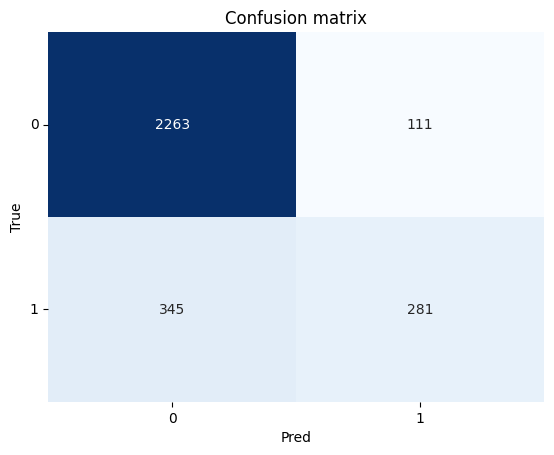

In [500]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
построим график

'''

plt.show()

In [501]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

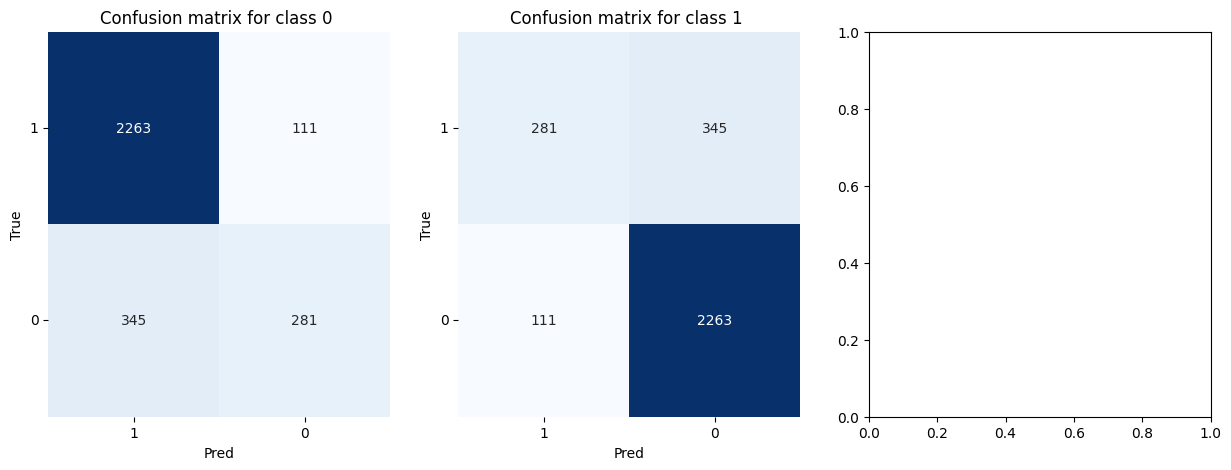

In [502]:
'''
Confusion matrix (для каждого класса по отдельности)
'''

classes = np.unique(y_test).astype(int)
lbs = [1,0]
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).
plt.grid - Настройка линий сетки.

'''
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5),dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test,class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)

'''
построим график

'''
plt.show()

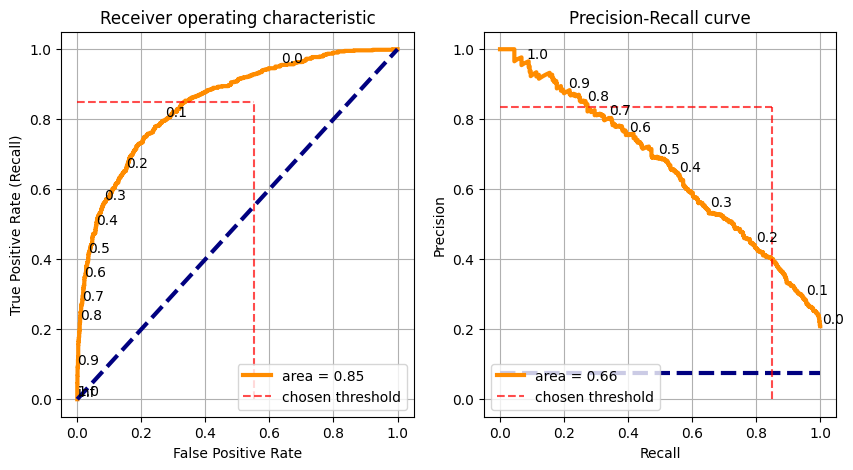

In [503]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)
'''

## plot ROC curve
построим кривую ROC

'''
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
'''
найдем пороговые значения ROC
'''

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
## plot P-R curve
'''
плстроим привую P-R
'''

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
'''
пороговые значения P-R
'''
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

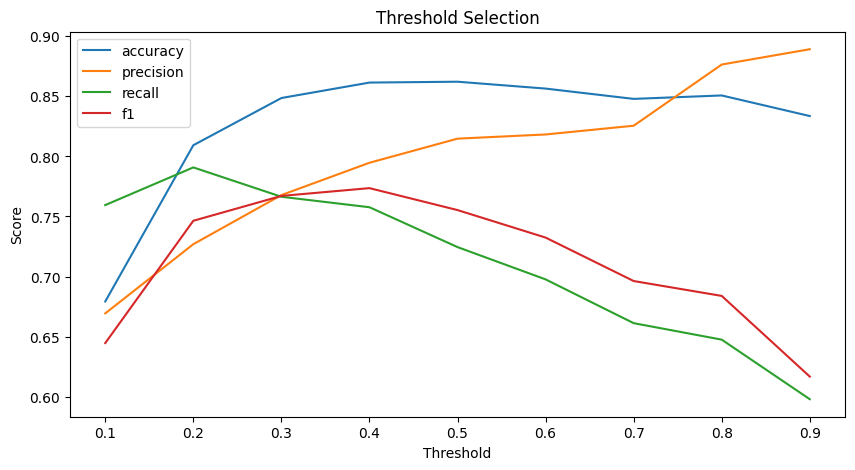

In [504]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
df_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
df_scores.plot(ax=ax)
'''
отрисовываем
'''

plt.show()